In [1]:
%matplotlib
# to add the spiking model codebase to the path
import sys
sys.path.append('..')

from results import Results
from analysis import (generate_description, FR_weights, determine_first_convergent_trial, determine_drift_rates,
                      FR_scatter, FR_hist2d, FR_hist1d_compare, FR_weights_std, weights_scatter_matrix,
                      weights_hist1d_compare, weights_matrix_compare, combine_two_sessions)

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Using matplotlib backend: Qt5Agg


INFO       Cache size for target "cython": 7893 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\mikejseay\.cython\brian_extensions" directory. [brian2]


In [25]:
plt.close('all')

In [32]:
targetPath = 'C:/Users/mikejseay/Documents/BrianResults/'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_guessGoodWeights2e3p025LogNormal_reMean_2021-08-19-20-37_results'
targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-outer-homeo_goodCrossHomeoExamp__2022-01-27-07-30-31_results'
# targetFile = 'classicJercog_2000_1_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p1LogNormal_fullConn_2021-08-13-09-38_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-outer-homeo_guessGoodWeights2e3p025LogNormal__2021-08-31-09-23_results'
# targetFile = 'buonoEphysBen1_2000_0p25_cross-homeo-pre-outer-homeo_guessBuono7Weights2e3p025SlightLow__2021-09-04-08-20_results'

In [33]:
R = Results()
R.init_from_file(targetFile, targetPath)

In [34]:
print(R.p['setUpFRExc'], R.p['tauUpFRTrials'], R.p['alpha1'], R.p['spikeInputAmplitude'])
plt.close('all')
pdfObject = PdfPages(targetPath + 'reports/' + R.rID + '_report.pdf')
removeOutliers = True

5. Hz 2 8. fC 0.98


In [35]:
generate_description(R)

FR_weights(R)
plt.savefig(pdfObject, format='pdf')

# firstConvergentInd = int(R.trialwEE.size / 2)
firstConvergentInd = 400
# firstConvergentInd = determine_first_convergent_trial(R)
# firstConvergentInd = determine_first_convergent_trial(R) + 1500
print('We think the first convergent index is', firstConvergentInd)

determine_drift_rates(R, firstConvergentInd)
print(R.driftRateEE)
print(R.driftRateEI)
print(R.driftRateIE)
print(R.driftRateII)

We think the first convergent index is 400
0.19381972799230637
-0.4396667802756437
-0.029965425974038326
-0.2424887071674788


In [36]:
# convergence process
FR_scatter(R, endTrialInd=firstConvergentInd)
plt.savefig(pdfObject, format='pdf')
FR_hist1d_compare(R, endTrialInd=firstConvergentInd)
plt.savefig(pdfObject, format='pdf')
FR_weights_std(R, endTrialInd=firstConvergentInd)
plt.savefig(pdfObject, format='pdf')
weights_scatter_matrix(R, endTrialInd=firstConvergentInd)
plt.savefig(pdfObject, format='pdf')

# post convergence
FR_scatter(R, startTrialInd=firstConvergentInd, removeOutliers=removeOutliers)
plt.savefig(pdfObject, format='pdf')
FR_hist2d(R, startTrialInd=firstConvergentInd, removeOutliers=removeOutliers)
plt.savefig(pdfObject, format='pdf')
FR_hist1d_compare(R, startTrialInd=firstConvergentInd)
plt.savefig(pdfObject, format='pdf')
FR_weights_std(R, startTrialInd=firstConvergentInd)
plt.savefig(pdfObject, format='pdf')
weights_scatter_matrix(R, startTrialInd=firstConvergentInd)
plt.savefig(pdfObject, format='pdf')

# epilogue
weights_hist1d_compare(R)
plt.savefig(pdfObject, format='pdf')
weights_matrix_compare(R)
plt.savefig(pdfObject, format='pdf')

pdfObject.close()

In [37]:
plt.close('all')

In [7]:
# imports for further development

from brian2 import pA, second, Hz
import numpy as np
from stats import moving_average, regress_linear, remove_outliers
from generate import weight_matrix_from_flat_inds_weights
from plot import weight_matrix
from scipy.stats import mode
from sklearn.neighbors import KernelDensity

In [8]:
# the following plot shows the weight matrices in a pretty labeled way

wEEInit = weight_matrix_from_flat_inds_weights(R.p['nExc'], R.p['nExc'], R.preEE, R.posEE, R.wEE_init)
wIEInit = weight_matrix_from_flat_inds_weights(R.p['nExc'], R.p['nInh'], R.preIE, R.posIE, R.wIE_init)
wEIInit = weight_matrix_from_flat_inds_weights(R.p['nInh'], R.p['nExc'], R.preEI, R.posEI, R.wEI_init)
wIIInit = weight_matrix_from_flat_inds_weights(R.p['nInh'], R.p['nInh'], R.preII, R.posII, R.wII_init)

wEEFinal = weight_matrix_from_flat_inds_weights(R.p['nExc'], R.p['nExc'], R.preEE, R.posEE, R.wEE_final)
wIEFinal = weight_matrix_from_flat_inds_weights(R.p['nExc'], R.p['nInh'], R.preIE, R.posIE, R.wIE_final)
wEIFinal = weight_matrix_from_flat_inds_weights(R.p['nInh'], R.p['nExc'], R.preEI, R.posEI, R.wEI_final)
wIIFinal = weight_matrix_from_flat_inds_weights(R.p['nInh'], R.p['nInh'], R.preII, R.posII, R.wII_final)

wFullInit = np.block([[wEEInit, wIEInit], [-wEIInit, -wIIInit]])
wFullFinal = np.block([[wEEFinal, wIEFinal], [-wEIFinal, -wIIFinal]])

allNumbers = np.concatenate((wFullInit, wFullFinal)).ravel()
allNumbersClean = remove_outliers(allNumbers)

vlims = (np.nanmin(allNumbersClean), np.nanmax(allNumbersClean))

wFullInitPlot = wFullInit.copy()
wFullFinalPlot = wFullFinal.copy()

wFullInitPlot[wFullInitPlot < vlims[0]] = np.nan
wFullInitPlot[wFullInitPlot > vlims[1]] = np.nan

wFullFinalPlot[wFullFinalPlot < vlims[0]] = np.nan
wFullFinalPlot[wFullFinalPlot > vlims[1]] = np.nan

wFullInitPlot[np.isnan(wFullInitPlot)] = 0
wFullFinalPlot[np.isnan(wFullFinalPlot)] = 0

useSize = 16

fig, ax = plt.subplots(figsize=(6, 5))
weight_matrix(ax, wFullFinalPlot, xlabel='Post Index', ylabel='Pre Index',
              clabel='Weight (pA)', limsMethod='custom', vlims=vlims)
ax.hlines(R.p['nExc'], 0, R.p['nUnits'], colors='k')
ax.vlines(R.p['nExc'], 0, R.p['nUnits'], colors='k')
ax.text(R.p['nExc'] / 2, R.p['nExc'] / 2, 'EE', size=useSize)
ax.text(R.p['nExc'] + R.p['nInh'] / 2, R.p['nExc'] / 2, 'IE', size=useSize)
ax.text(R.p['nExc'] / 2, R.p['nExc'] + R.p['nInh'] / 2, 'EI', size=useSize)
ax.text(R.p['nExc'] + R.p['nInh'] / 2, R.p['nExc'] + R.p['nInh'] / 2, 'II', size=useSize)
ax.set(xlim=(0, R.p['nUnits']), ylim=(0, R.p['nUnits']))

[(0.0, 2000.0), (0.0, 2000.0)]

In [13]:
print(np.nanmean(wEEFinal))
print(np.nanmean(wIEFinal))
print(np.nanmean(wEIFinal))
print(np.nanmean(wIIFinal))

252.07347
264.48114
307.73352
281.88086


In [ ]:
# a plot for a single trial



In [22]:
plt.close('all')

In [31]:
print(np.nanmean(R.wEE_final))
print(np.nanmean(R.wEI_final))
print(np.nanmean(R.wIE_final))
print(np.nanmean(R.wII_final))

311.39233
388.17596
222.7006
195.84949


In [ ]:
# what about cumulative prob at a certain percent

In [74]:
# v1.2

f, ax = plt.subplots(num=1)

movAvgWidth = 31

wEEDiffAbsMAvg = np.fabs(moving_average(np.ediff1d(R.trialwEE), movAvgWidth))
wEIDiffAbsMAvg = np.fabs(moving_average(np.ediff1d(R.trialwEI), movAvgWidth))
wIEDiffAbsMAvg = np.fabs(moving_average(np.ediff1d(R.trialwIE), movAvgWidth))
wIIDiffAbsMAvg = np.fabs(moving_average(np.ediff1d(R.trialwII), movAvgWidth))

wSum = wEEDiffAbsMAvg + wEIDiffAbsMAvg + wIEDiffAbsMAvg + wIIDiffAbsMAvg
wSumMode = mode(wSum)[0][0]

belowThreshBool = wSum < (wSum.mean() + wSumMode) / 2
belowThreshBoolMAvg = moving_average(belowThreshBool, 51)
if np.any(belowThreshBoolMAvg == 1):
    firstConvergentInd = np.argmax(belowThreshBoolMAvg == 1)
else:
    alpha = 0.05
    nTrials = belowThreshBoolMAvg.size
    thresholdInd = int(np.round((1 - alpha) * nTrials))
    thresholdValue = np.sort(belowThreshBoolMAvg)[thresholdInd]
    firstConvergentInd = np.argmax(belowThreshBoolMAvg >= thresholdValue)

alpha = 0.05
nTrials = belowThreshBoolMAvg.size
thresholdInd = int(np.round((1 - alpha) * nTrials))
thresholdValue = np.sort(belowThreshBoolMAvg)[thresholdInd]
firstConvergentInd = np.argmax(belowThreshBoolMAvg >= thresholdValue)

ax.plot(wSum)
ax.hlines(0, 0, R.trialwEE.size)
ax.hlines(wSum.mean(), 0, R.trialwEE.size, color='r', ls='--')
# ax.hlines(wSumMode, 0, R.trialwEE.size, color='g', ls='--')
ax.hlines((wSum.mean() + wSumMode) / 2, 0, R.trialwEE.size, color='b', ls='--')
ax.vlines(firstConvergentInd, ax.get_ylim()[0], ax.get_ylim()[1], color='g', ls='--')
# ax.set_xlim(0, 2000)
ax.set_ylim(0, 0.1)

(0, 0.1)

In [78]:
f, ax = plt.subplots()
ax.plot(belowThreshBoolMAvg)
ax.vlines(firstConvergentInd, ax.get_ylim()[0], ax.get_ylim()[1], color='g', ls='--')

In [49]:
firstConvergentInd

0

In [32]:
alpha = 0.1
alphaInd = int(np.round(wSum.size * (1 - alpha)))

np.sort(wSum)[alphaInd]

0.013143943818654462

In [27]:
wCumSort = np.cumsum(np.sort(wSum))

In [28]:
f, ax = plt.subplots()
ax.plot(wCumSort)

In [24]:
wSum.mean()

0.011037429225254969

In [15]:
x = wSum
x_d = np.linspace(wSum.min(), wSum.max(), 1000)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

f, ax = plt.subplots()
ax.fill_between(x_d, np.exp(logprob), alpha=0.5)
ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

In [19]:
f, ax = plt.subplots()
ax.hist(wSum, 100, histtype='step')

(array([5.463e+03, 5.100e+02, 1.010e+02, 1.070e+02, 2.600e+01, 3.800e+01,
        2.500e+01, 2.100e+01, 1.300e+01, 1.400e+01, 3.900e+01, 2.000e+01,
        2.400e+01, 1.700e+01, 2.800e+01, 2.700e+01, 2.500e+01, 3.500e+01,
        3.400e+01, 5.900e+01, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+0

In [ ]:
belowThreshBool = wSum < wSum.mean()
belowThreshBoolMAvg = moving_average(belowThreshBool, movAvgWidth)
firstConvergentInd = np.argmax(belowThreshBoolMAvg == 1)

In [3]:
targetPath = 'C:/Users/mikejseay/Documents/BrianResults/'
# local
# targetFile = 'classicJercog_2000_0p25_cross-homeo-scalar_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-05-00-57_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-05-00-57_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar_guessGoodWeights2e3p025LogNormal__2021-08-03-10-00_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal__2021-08-02-14-26_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg2_2021-08-04-11-12_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg4_2021-08-04-11-13_results'
targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-05-11-02_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-scalar-homeo_guessUpperLeftWeights2e3p025LogNormal_movAvg1_2021-08-05-23-54_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg8_2021-08-05-11-03_results'

# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessUpperLeftWeights2e3p025LogNormal_movAvg1_2021-08-06-10-42_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessLowerRightWeights2e3p025LogNormal_movAvg1_2021-08-06-09-01_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_lowNoise_2021-08-07-09-04_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_lowNoiseBigKickPop_2021-08-07-09-08_results'

# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-corrected_guessGoodWeights2e3p025LogNormal_fixSigns_2021-08-09-09-10_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-05-11-02_results'

# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-corrected_guessLowerRightWeights2e3p025LogNormal_fixSigns_2021-08-10-13-52_results'

# targetPath = 'C:/Users/mikejseay/Documents/BrianResultsHoff/'
# hoff
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessUpperLeftWeights2e3p025LogNormal_movAvg1_2021-08-05-17-00_results'  # was a very bad guess... actually lower RIGHT
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-05-21-06_results'   # findout out the upper left weights...

In [403]:
# goal: evaluate the average weight change according to various rules for the ACTUAL mean weights

startTrialInd = 1000
endTrialInd = -1

# f, ax = plt.subplots()
plt.hist2d(R.trialUpFRExc[startTrialInd:endTrialInd], R.trialUpFRInh[startTrialInd:endTrialInd], bins=50)
# ax.plot(R.trialUpFRExc, R.trialUpFRInh, color='k', alpha=0.1)
ax.hlines(R.p['setUpFRInh'] / Hz, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted')
ax.vlines(R.p['setUpFRExc'] / Hz, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dotted')
ax.set_xlabel('E (Hz)')
ax.set_ylabel('I (Hz)')

plt.colorbar()
plt.show()

In [15]:
# scattering weights before and after ??

downSampleFactorForE = 0.25
downSampleNForE = int(downSampleFactorForE * wEEInitP.size)

fig4, ax4 = plt.subplots(2, 1, figsize=(7, 9))

ax4[0].scatter(wEEInitP[:downSampleNForE], wEIInitP[:downSampleNForE], 1, color='lightgreen')
ax4[0].scatter(wEEFinalP[:downSampleNForE], wEIFinalP[:downSampleNForE], 1, color='darkgreen', marker='^')
ax4[0].plot(np.stack((wEEInitP[:downSampleNForE], wEEFinalP[:downSampleNForE])),
            np.stack((wEIInitP[:downSampleNForE], wEIFinalP[:downSampleNForE])), color='grey', alpha=0.02)

ax4[1].scatter(wIEInitP, wIIInitP, 1, color='lightcoral')
ax4[1].scatter(wIEFinalP, wIIFinalP, 1, color='darkred', marker='^')
ax4[1].plot(np.stack((wIEFinalP, wIEInitP)), np.stack((wIIFinalP, wIIInitP)), color='grey', alpha=0.1)

ax4[0].set(xlabel='wEE (pA)', ylabel='wEI (pA)')
ax4[1].set(xlabel='wEE (pA)', ylabel='wEI (pA)')

[Text(0, 0.5, 'wEI (pA)'), Text(0.5, 0, 'wEE (pA)')]

In [260]:
# goal: scatter plot the average change in E firing rate vs. I firing rate for each trial

FRDiffExc = np.ediff1d(R.trialUpFRExc)
FRDiffInh = np.ediff1d(R.trialUpFRInh)

f, ax = plt.subplots()
s = ax.scatter(FRDiffExc, FRDiffInh, s=3, c=np.arange(FRDiffExc.size) + 2, cmap=plt.cm.viridis, alpha=0.5)
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted')
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dotted')
ax.set_xlabel('delta E (Hz)')
ax.set_ylabel('delta I (Hz)')

cb = plt.colorbar(s, ax=ax)
cb.ax.set_ylabel('Trial Index', rotation=270)

Text(0, 0.5, 'Trial Index')

In [15]:
# goal: scatter plot the average change in wEE vs. wEI

wEEDiff = np.ediff1d(R.trialwEE)
wEIDiff = np.ediff1d(R.trialwEI)

wIEDiff = np.ediff1d(R.trialwIE)
wIIDiff = np.ediff1d(R.trialwII)

f, ax = plt.subplots(2, 1, figsize=(6, 11))

s = ax[0].scatter(wEEDiff, wEIDiff, s=3, c=np.arange(wEEDiff.size) + 2, cmap=plt.cm.viridis, alpha=0.5)
ax[0].set_xlabel('delta wEE (pA)')
ax[0].set_ylabel('delta wEI (pA)')

s = ax[1].scatter(wIEDiff, wIIDiff, s=3, c=np.arange(wIEDiff.size) + 2, cmap=plt.cm.viridis, alpha=0.5)
ax[1].set_xlabel('delta wIE (pA)')
ax[1].set_ylabel('delta wII (pA)')
cb = plt.colorbar(s, ax=ax)
cb.ax.set_ylabel('Trial Index', rotation=270)

Text(0, 0.5, 'Trial Index')

In [409]:
f, ax = plt.subplots()
ax.plot(R.trialUpDur)

FR and weights, multiple lines

In [43]:
startTrialInd = 0
endTrialInd = 500

f, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 9))

# FRs on bottom...

clipVeryHighFRs = False
yMax = 40

if clipVeryHighFRs:
    tmptrialUpFRExcUnits = R.trialUpFRExcUnits.copy()
    tmptrialUpFRInhUnits = R.trialUpFRInhUnits.copy()
    tmptrialUpFRExcUnits[R.trialUpFRExcUnits > R.p['maxAllowedFRExc']] = np.nan
    tmptrialUpFRInhUnits[R.trialUpFRInhUnits > R.p['maxAllowedFRInh']] = np.nan
else:
    tmptrialUpFRExcUnits = R.trialUpFRExcUnits.copy()
    tmptrialUpFRInhUnits = R.trialUpFRInhUnits.copy()

    
ax[0].plot(R.trialwEE[startTrialInd:endTrialInd], label='wEE', color='cyan')
ax[0].plot(R.trialwIE[startTrialInd:endTrialInd], label='wIE', color='purple')
ax[0].plot(R.trialwEI[startTrialInd:endTrialInd], label='wEI', color='cyan', ls='--')
ax[0].plot(R.trialwII[startTrialInd:endTrialInd], label='wII', color='purple', ls='--')
ax[0].legend()
ax[0].set_xlabel('Trial #')
ax[0].set_ylabel('Weight (pA)')

ax[1].plot(tmptrialUpFRExcUnits[startTrialInd:endTrialInd, downSampleE], color='g', alpha=0.2)
ax[2].plot(tmptrialUpFRInhUnits[startTrialInd:endTrialInd, downSampleI], color='r', alpha=0.2)
ax[1].plot(R.trialUpFRExc[startTrialInd:endTrialInd], color='darkgreen', lw=3)
ax[2].plot(R.trialUpFRInh[startTrialInd:endTrialInd], color='darkred', lw=3)
ax[1].set(ylabel='Firing Rate (Hz)', ylim=(0, 30))
ax[2].set(ylabel='Firing Rate (Hz)', ylim=(0, 30))

f.suptitle(importantInfoString)

Text(0.5, 0.98, 'Name: classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessLowerRightWeights2e3p025LogNormal_movAvg1_2021-08-06-09-01\nEE: 1, IE: 1, EI: 1, II: 1\n tauFR=1, a1=0.0080 pA, a2=-1.0000 pA, tauP=None')

FR and weights, multiple lines, multiple sessions

In [18]:
for targetFile in crossHomeoLongSessions:

    R = Results()
    R.init_from_file(targetFile, targetPath)
    
    trialUpFRExcUnitsSTD = np.std(R.trialUpFRExcUnits)
    trialUpFRInhUnitsSTD = np.std(R.trialUpFRInhUnits)

    if R.p['useRule'][:5] == 'cross':
        R.p['alpha2'] = -1e-12
        R.p['tauPlasticityTrials'] = None
    if 'wEEScale' not in R.p:
        R.p['wEEScale'] = None
        R.p['wIEScale'] = None
        R.p['wEIScale'] = None
        R.p['wIIScale'] = None

    importantInfoString = 'Name: {}\nEE: {}, IE: {}, EI: {}, II: {}\n tauFR={}, a1={:.4f} pA, a2={:.4f} pA, tauP={}'.format(R.rID,
        R.p['wEEScale'],R.p['wIEScale'],R.p['wEIScale'],R.p['wIIScale'],
        R.p['tauUpFRTrials'], R.p['alpha1'] / pA, R.p['alpha2'] / pA, R.p['tauPlasticityTrials'])

    f, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 9))

    # FRs on bottom...

    clipVeryHighFRs = False
    yMax = 40

    ax[0].plot(R.trialwEE, label='wEE', color='cyan')
    ax[0].plot(R.trialwIE, label='wIE', color='purple')
    ax[0].plot(R.trialwEI, label='wEI', color='cyan', ls='--')
    ax[0].plot(R.trialwII, label='wII', color='purple', ls='--')
    ax[0].legend()
    ax[0].set_xlabel('Trial #')
    ax[0].set_ylabel('Weight (pA)')

    ax[1].plot(R.trialUpFRExc, color='darkgreen', lw=1)
    ax[2].plot(R.trialUpFRInh, color='darkred', lw=1)
    
    ax[1].fill_between(np.arange(R.trialUpFRExc.size),
                   R.trialUpFRExc - trialUpFRExcUnitsSTD,
                   R.trialUpFRExc + trialUpFRExcUnitsSTD,
                   color='green', alpha=0.1)

    ax[2].fill_between(np.arange(R.trialUpFRInh.size),
                       R.trialUpFRInh - trialUpFRInhUnitsSTD,
                       R.trialUpFRInh + trialUpFRInhUnitsSTD,
                       color='red', alpha=0.1)
    
    ax[1].set(ylabel='Firing Rate (Hz)', ylim=(0, 30))
    ax[2].set(ylabel='Firing Rate (Hz)', ylim=(0, 30))

    f.suptitle(importantInfoString)

NameError: name 'crossHomeoLongSessions' is not defined

In [44]:
# since the weight matrix elements represent the connection FROM the row indexed unit TO the column indexed unit,
# the mean of INCOMING weights onto each unit is given by taking the mean along the row dimension (0)
# the mean of OUTGOING weights onto each unit is given by taking the mean along the column dimension (1)

In [56]:
print(wEEInit.shape)
print(wEIInit.shape)
print(wIEInit.shape)
print(wIIInit.shape)

(1600, 1600)
(1600, 400)
(400, 1600)
(400, 400)


In [59]:
len('cross-homeo-scalar')

18

In [58]:
wEEInitIncoming = np.nanmean(wEEInit, 0)
wEIInitIncoming = np.nanmean(wEIInit, 0)
wIEInitIncoming = np.nanmean(wIEInit, 0)
wIIInitIncoming = np.nanmean(wIIInit, 0)

In [52]:
R.trialdwIEUnits[0, :]

array([-0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911293,
       -0.0911293, -0.0911293, -0.0911293, -0.0911293, -0.0911

In [53]:
test = np.isnan(wEEInit)

In [55]:
wEEInit[test] = 0

In [47]:
wIEInitIncoming.shape

(400,)

In [48]:
R.trialdwIEUnits.shape

(6765, 400)

In [49]:
wEIInitIncoming.shape

(1600,)

In [50]:
R.trialdwEIUnits.shape

(6765, 1600)

In [36]:
test = np.nanmean(wEEInit, 0)

In [38]:
test2 = np.nanmean(wEEInit, 1)

In [37]:
test

array([122.63855 , 127.911026, 118.092354, ..., 123.24856 , 124.19884 ,
       107.14553 ], dtype=float32)

In [39]:
test2

array([124.808   , 126.54074 , 117.35509 , ..., 121.43316 , 114.129234,
       107.79609 ], dtype=float32)

In [40]:
test3 = np.array([[1, 2, 3,], [4, 5, 6]])

In [42]:
test3

array([[1, 2, 3],
       [4, 5, 6]])

In [43]:
test3.mean(0)

array([2.5, 3.5, 4.5])

In [41]:
test3.mean(1)

array([2., 5.])

In [27]:
# individual FRs, bad version

clipVeryHighFRs = False
yMax = 40

if clipVeryHighFRs:
    tmptrialUpFRExcUnits = R.trialUpFRExcUnits.copy()
    tmptrialUpFRInhUnits = R.trialUpFRInhUnits.copy()
    tmptrialUpFRExcUnits[R.trialUpFRExcUnits > R.p['maxAllowedFRExc']] = np.nan
    tmptrialUpFRInhUnits[R.trialUpFRInhUnits > R.p['maxAllowedFRInh']] = np.nan
else:
    tmptrialUpFRExcUnits = R.trialUpFRExcUnits.copy()
    tmptrialUpFRInhUnits = R.trialUpFRInhUnits.copy()

fig3, ax3 = plt.subplots(2, figsize=(5, 9), sharex=True)
ax3[0].plot(tmptrialUpFRExcUnits[:, downSampleE], color='g', alpha=0.2)
ax3[1].plot(tmptrialUpFRInhUnits[:, downSampleI], color='r', alpha=0.2)
ax3[0].plot(R.trialUpFRExc, color='darkgreen', lw=3)
ax3[1].plot(R.trialUpFRInh, color='darkred', lw=3)

ax3[0].set(ylabel='Firing Rate (Hz)') # , xlim=(0, 100), ylim=(0, 15))
ax3[1].set(ylabel='Firing Rate (Hz)') #, xlabel='Trial Index', xlim=(0, 100), ylim=(0, 30))

[Text(0, 0.5, 'Firing Rate (Hz)')]

In [23]:
# weights over trials, bad version

f, axs = plt.subplots(2, 2, sharex=True)
axArr = axs.ravel()

wColors = ('lightskyblue', 'purple', 'lightskyblue', 'purple', )
wColorsDark = ('deepskyblue', 'indigo', 'deepskyblue', 'indigo',)
wLinestyles = ('-', '-', '--', '--', )

dwMats = ('trialdwEEUnits',
          'trialdwIEUnits',
          'trialdwEIUnits',
          'trialdwIIUnits',
         )

wInitMats = (wEEInitP,
          wIEInitP,
          wEIInitP,
          wIIInitP,
         )

scalers = (R.p['wEEScale'],
          R.p['wIEScale'],
          R.p['wEIScale'],
          R.p['wIIScale'],)

for axInd, ax in enumerate(axArr):
    values = getattr(R, dwMats[axInd]) * scalers[axInd]
    values = wInitMats[axInd] + values.cumsum(0)
    print(values.shape)
    
    ax.plot(values, alpha=0.1, color=wColors[axInd], ls=wLinestyles[axInd])
    ax.plot(values.mean(1), lw=2, color=wColorsDark[axInd], ls=wLinestyles[axInd])
#     valuesNorm = values / np.max(np.fabs(values))
#     ax.plot(valuesNorm, alpha=0.1)
#     ax.plot(values.cumsum(0), alpha=0.1)
#     ax.plot(wInitMats[axInd] + values.cumsum(0), alpha=0.1)
    
    ax.set_xlabel('Trial #')
    ax.set_ylabel('Summed current (pA)')
    ax.set(title=dwMats[axInd])

prune_figure(axs, pruneYTicks=False)

(6765, 1600)
(6765, 400)
(6765, 1600)
(6765, 400)


In [32]:
# weight changes over trials, bad version

clipVeryHighFRs = True

if clipVeryHighFRs:
    R.trialUpFRExcUnits[R.trialUpFRExcUnits > R.p['maxAllowedFRExc']] = np.nan
    R.trialUpFRInhUnits[R.trialUpFRInhUnits > R.p['maxAllowedFRInh']] = np.nan

fig3, ax3 = plt.subplots(2, figsize=(10, 9), gridspec_kw={'height_ratios': [4, 1]})
i = ax3[0].imshow(R.trialUpFRExcUnits.T,
               cmap='Greys',
               aspect='auto',
               interpolation='none',
               origin='lower')
cb = plt.colorbar(i, ax=ax3[0])
i = ax3[1].imshow(R.trialUpFRInhUnits.T,
               cmap='Greys',
               aspect='auto',
               interpolation='none',
               origin='lower')
cb = plt.colorbar(i, ax=ax3[1])

In [34]:
# weight changes over trials, bad version

fig3, ax3 = plt.subplots(2, 2, figsize=(10, 9), gridspec_kw={'height_ratios': [4, 1]})
i = ax3[0, 0].imshow(R.trialdwEEUnits.T,
               cmap='Greys',
               aspect='auto',
               interpolation='none',
               origin='lower')
cb = plt.colorbar(i, ax=ax3[0, 0])
i = ax3[0, 1].imshow(R.trialdwIEUnits.T,
               cmap='Greys',
               aspect='auto',
               interpolation='none',
               origin='lower')
cb = plt.colorbar(i, ax=ax3[0, 1])
i = ax3[1, 0].imshow(R.trialdwEIUnits.T,
               cmap='Greys',
               aspect='auto',
               interpolation='none',
               origin='lower')
cb = plt.colorbar(i, ax=ax3[1, 0])
i = ax3[1, 1].imshow(R.trialdwIIUnits.T,
               cmap='Greys',
               aspect='auto',
               interpolation='none',
               origin='lower')
cb = plt.colorbar(i, ax=ax3[1, 1])

In [35]:
# weight changes over trials, bad version 2

f, axs = plt.subplots(2, 2)
axArr = axs.ravel()

dwMats = ('trialdwEEUnits',
          'trialdwEIUnits',
          'trialdwIEUnits',
          'trialdwIIUnits',
         )

for axInd, ax in enumerate(axArr):
    values = getattr(R, dwMats[axInd]).T
    i = ax.imshow(values,
                 cmap=plt.cm.RdBu_r,
                 aspect='auto',
                 interpolation='none')
    ax.set_xlabel('Trial #')
    ax.set_ylabel('Unit Index')
    
    vmax, vmin = np.max(values), np.min(values)
    norm = MidpointNormalize(vmin, vmax, 0)
    i.set_clim(vmin, vmax)
    i.set_norm(norm)
    
    cb = plt.colorbar(i, ax=ax)
    if axInd in (1, 3):
        cb.ax.set_ylabel('Weight (pA)')
        
    ax.set_title(dwMats[axInd])

prune_figure(axs)

In [1]:
from itertools import product

In [5]:
list(product(list(range(3)), list(range(3))))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [10]:
excMeanWeightsPossible = (75, 112.5, 150)
inhMeanWeightsPossible = (700, 450, 200)
mappingStringSeq = (('wIE', 'wEE'), ('wII', 'wEI'),)
excWeightTupleList = list(product(excMeanWeightsPossible, excMeanWeightsPossible))
inhWeightTupleList = list(product(inhMeanWeightsPossible, inhMeanWeightsPossible))

In [55]:
logNormNums = np.random.lognormal(0, 0.75, (1000,))
logNormNums /= logNormNums.mean()
print(logNormNums.mean(), np.std(logNormNums), logNormNums.min(), logNormNums.max())

1.0 0.8392199274933195 0.06740215278227316 7.230029105824054


In [48]:
f, ax = plt.subplots()
ax.hist(logNormNums, histtype='step')

(array([607., 268.,  87.,  25.,   6.,   4.,   1.,   0.,   0.,   2.]),
 array([0.08403355, 0.95236029, 1.82068703, 2.68901378, 3.55734052,
        4.42566726, 5.293994  , 6.16232074, 7.03064748, 7.89897423,
        8.76730097]),
 <a list of 1 Patch objects>)

In [11]:
print(excWeightTupleList)

[(75, 75), (75, 112.5), (75, 150), (112.5, 75), (112.5, 112.5), (112.5, 150), (150, 75), (150, 112.5), (150, 150)]


In [12]:
print(inhWeightTupleList)

[(700, 700), (700, 450), (700, 200), (450, 700), (450, 450), (450, 200), (200, 700), (200, 450), (200, 200)]


In [25]:
nUnits = 10
pConn = 1
allowAutapses = False

In [33]:
bestNumberOfSynapses = int(np.round(pConn * nUnits ** 2))
print(bestNumberOfSynapses)

if allowAutapses:
    indicesFlat = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False)
else:
    probabilityArray = np.full((nUnits, nUnits), 1 / (nUnits * (nUnits - 1)))
    probabilityArray[np.diag_indices_from(probabilityArray)] = 0
    
    if pConn > (nUnits - 1) / nUnits:
        bestNumberOfSynapses -= int(np.round(nUnits ** 2 * (pConn - (nUnits - 1) / nUnits)))
        print(bestNumberOfSynapses)
    
    indicesFlat = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False, p=probabilityArray.ravel())

preInds, postInds = np.unravel_index(indicesFlat, (nUnits, nUnits))

100
90


In [32]:
int(np.round(nUnits ** 2 * (pConn - (nUnits - 1) / nUnits)))

10

In [28]:
int(np.round(((1 - pConn) * nUnits ** 2)))

0

In [ ]:
bestNumbe

In [4]:
# goal 2: apply normally distributed weights

In [15]:
nExc = 8
nInh = 2
pConn = 0.25
randnMean = 1
randnSD = 0.2

aEE = generate_adjacency_matrix_within(nExc, pConn, allowAutapses=False)
aIE = generate_adjacency_matrix_between(nExc, nInh, pConn)
aEI = generate_adjacency_matrix_between(nInh, nExc, pConn)
aII = generate_adjacency_matrix_within(nInh, pConn, allowAutapses=False)

wEE = w_from_a(aEE, randnMean, randnSD)
wIE = w_from_a(aIE, randnMean, randnSD)
wEI = w_from_a(aEI, randnMean, randnSD)
wII = w_from_a(aII, randnMean, randnSD)

In [16]:
wEE

array([[0.        , 1.14111646, 0.        , 0.        , 0.91245524,
        0.        , 0.        , 0.58845372],
       [0.        , 0.        , 0.        , 0.6840502 , 0.        ,
        0.        , 0.85097995, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.10777655],
       [1.32835325, 0.        , 0.        , 0.        , 0.93841501,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.06376324, 0.        , 0.        ,
        1.08381029, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.1919193 , 0.        ,
        0.        , 0.        , 0.70794324],
       [0.        , 1.26854389, 0.        , 0.8659907 , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.80745652, 0.        ,
        0.        , 1.12804687, 0.        ]])

In [6]:
preInds, postInds = np.where(aEE)

In [7]:
preInds 

array([0, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 7, 7, 7], dtype=int64)

In [8]:
postInds

array([2, 0, 2, 4, 6, 4, 5, 1, 5, 5, 4, 6, 0, 0, 2, 4], dtype=int64)

In [11]:
weights = np.random.normal(size=preInds.size)

In [12]:
weights

array([ 0.54428341,  0.42842826, -0.1290585 , -1.68726729,  0.40761932,
       -0.48984529,  0.14953924,  0.58476359,  0.39997037,  1.15748391,
        0.325102  , -0.43593126, -1.13064903, -0.70461682,  1.49334686,
        0.0551257 ])

In [13]:
wEE[preInds, postInds] = weights

In [14]:
wEE

array([[ 0.        ,  0.        ,  0.54428341,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.42842826,  0.        , -0.1290585 ,  0.        , -1.68726729,
         0.        ,  0.40761932,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.48984529,
         0.14953924,  0.        ,  0.        ],
       [ 0.        ,  0.58476359,  0.        ,  0.        ,  0.        ,
         0.39997037,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.15748391,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.325102  ,
         0.        , -0.43593126,  0.        ],
       [-1.13064903,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.70461682,  0.        ,  1.49334686,  0.        ,  0.0551257 ,
         0.        ,  0.        ,  0.        ]])

In [6]:
wFull = np.block([[wEE, wIE],[-wEI, -wII]])

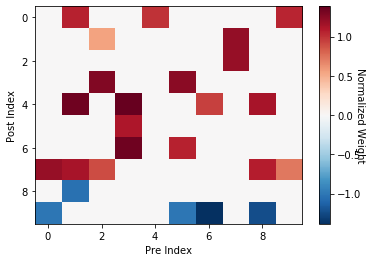

In [7]:
f, ax = plt.subplots()
weight_matrix(ax, wFull,
                   xlabel='Pre Index',
                   ylabel='Post Index',
                   clabel='Normalized Weight',)

In [174]:
f, ax = plt.subplots()
i = ax.imshow(wFull,
              cmap='RdBu_r',
              aspect='auto',
              interpolation='none', )
ax.set(xlabel='Post Index', ylabel='Pre Index')
cb = plt.colorbar(i, ax=ax)
cb.ax.set_ylabel('Normalized Weight', rotation=270)

Text(0, 0.5, 'Normalized Weight')

In [104]:
def method2():
    # more exact method
    nUnits = 10000
    pConn = 0.05
    allowAutapses = False

    bestNumberOfSynapses = int(np.round(pConn * nUnits ** 2))
    roughIndices = np.random.choice(nUnits ** 2, bestNumberOfSynapses, replace=False)
    adjMat = np.zeros((nUnits, nUnits), dtype=bool)
    adjMat[np.unravel_index(roughIndices, (nUnits, nUnits))] = True
    print(adjMat)
    traceRough = np.trace(adjMat)
    adjMat[np.diag_indices_from(adjMat)] = False
    nonDiagonalZeroBool = ~(np.eye(nUnits, dtype=bool) | adjMat)
    nonDiagonalIndicesFlattened = np.ravel_multi_index(np.where(nonDiagonalZeroBool), (nUnits, nUnits))
    newSynapseIndices = np.random.choice(nonDiagonalIndicesFlattened, traceRough, replace=False)
    adjMat[np.unravel_index(newSynapseIndices, (nUnits, nUnits))] = True

In [2]:
# goal 0: create a concise presentation of model parameters and compare two
# actually on second thought this doesn't really matter

importantParams = ['nUnits', 'propConnect', ]
from params import paramsJercog, paramsDestexhe
import pandas as pd
paramsJercog

In [9]:
print('wEE mult:', R.trialwEE[-1] / R.trialwEE[0])
print('wIE mult:', R.trialwIE[-1] / R.trialwIE[0])
print('wEI mult:', R.trialwEI[-1] / R.trialwEI[0])
print('wII mult:', R.trialwII[-1] / R.trialwII[0])

wEE mult: 1.5280555838516545
wIE mult: 1.3184911495933698
wEI mult: 1.9576444879836656
wII mult: 1.8852440442085339


In [10]:
print('wEE mult:', R.trialwEE[450] / R.trialwEE[0])
print('wIE mult:', R.trialwIE[450] / R.trialwIE[0])
print('wEI mult:', R.trialwEI[450] / R.trialwEI[0])
print('wII mult:', R.trialwII[450] / R.trialwII[0])

wEE mult: 1.184605613007468
wIE mult: 1.0560333163489584
wEI mult: 1.346584426306244
wII mult: 1.2871234460198888


In [11]:
print('wEE mult:', R.wEE_final.mean() / R.wEE_init.mean())
print('wIE mult:', R.wIE_final.mean() / R.wIE_init.mean())
print('wEI mult:', R.wEI_final.mean() / R.wEI_init.mean())
print('wII mult:', R.wII_final.mean() / R.wII_init.mean())

wEE mult: 0.9980488751419867
wIE mult: 0.9999039713855463
wEI mult: 1.0002111869462413
wII mult: 1.0002430924208603


In [12]:
R.wEE_final.mean()

1.06755195e-11

In [13]:
R.wEE_final.mean()

1.06755195e-11

In [30]:
dwEE1 = np.random.randint(1, 2, (1, 4)) * pA
dwEE2 = np.random.randint(1, 2, (4, 1)) * pA
dwEE3 = np.random.randint(1, 2, (4,)) * pA
dwEE1[:, 2:] = 2 * pA
dwEE2[2:] = 2 * pA
dwEE3[2:] = 2 * pA

In [31]:
dwEE1

array([[1., 1., 2., 2.]]) * pamp

In [32]:
dwEE2

array([[1.],
       [1.],
       [2.],
       [2.]]) * pamp

In [33]:
dwEE3

array([1., 1., 2., 2.]) * pamp

In [34]:
dwEE1.shape

(1, 4)

In [35]:
dwEE2.shape

(4, 1)

In [36]:
dwEE3.shape

(4,)

In [37]:
wEE + dwEE1

array([[ 2., 11.,  4.,  5.],
       [ 7.,  4., 13., 15.],
       [ 2., 10., 15., 15.],
       [ 8.,  9., 14.,  7.]]) * pamp

In [38]:
wEE + dwEE2

array([[ 2., 11.,  3.,  4.],
       [ 7.,  4., 12., 14.],
       [ 3., 11., 15., 15.],
       [ 9., 10., 14.,  7.]]) * pamp

In [39]:
wEE + dwEE3

array([[ 2., 11.,  4.,  5.],
       [ 7.,  4., 13., 15.],
       [ 2., 10., 15., 15.],
       [ 8.,  9., 14.,  7.]]) * pamp

In [ ]:
wEE + dwEE1

In [41]:
scale1 = np.array([1, 1, 1, 1])
scale2 = np.array([.25, .25, 1, 1])
scale3 = np.array([.25, .125, 1, .5])

In [83]:
scale2.mean() * .75

0.46875

In [84]:
scale3.mean()

0.46875

In [14]:
fig4a, ax4a = plt.subplots(2, 1, figsize=(4, 9), sharex=True, sharey=True)
fig4b, ax4b = plt.subplots(2, 1, figsize=(4, 9), sharex=True, sharey=True)

ax4a[0].scatter(wEEInitP, wEIInitP, 1, color='g')
ax4a[1].scatter(wEEFinalP, wEIFinalP, 1, color='g')
ax4b[0].scatter(wIEFinalP, wIIFinalP, 1, color='r')
ax4b[1].scatter(wIEInitP, wIIInitP, 1, color='r')

ax4a[0].set(xlabel='init wEE (pA)', ylabel='init wEI (pA)')
ax4a[1].set(xlabel='last wEE (pA)', ylabel='last wEI (pA)')
ax4b[0].set(xlabel='init wIE (pA)', ylabel='init wII (pA)')
ax4b[1].set(xlabel='last wEE (pA)', ylabel='last wEI (pA)')

[Text(0, 0.5, 'last wEI (pA)'), Text(0.5, 0, 'last wEE (pA)')]

In [5]:
# targetFile = 'jercogDefaultP05_2021-04-18-18-58_results'  # cross-homeo
# targetFile = 'jercogDefaultP05_2021-04-18-21-36_results'  # balance
# targetFile = 'jercogDefaultP05_2021-04-18-23-01_results'  # test

# targetFile = 'destexheDefaultP02_2021-04-19-22-43_results'  # cross-homeo

# weight changes customized separately
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-23-00-52_cross-homeo_results'  # starting from good weights?
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-23-01-17_cross-homeo_results'  # starting from bad weights
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-24-20-55_balance_results'  # starting from good weights?
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-25-15-07_balance_results'  # starting from bad weights
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-25-21-10_balance_results'  # starting from good weights?
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-08-56_balance_results'  # starting from good weights?
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-09-11_balance_results'  # starting from good weights, no weight change scaling
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-11-26_balance_results'  # starting from good weights, weight change scaling
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-14-10_balance_results'  # starting from good weights, weight change scaling with the membrane tau scaling
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-16-25_balance_results'  # starting from good weights, weight change scaling with the membrane tau scaling, alpha 10x
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-16-27_balance_results'  # carefully altered init weights (.75, 1.25, 1.5, 0.5), weight change scaling with the membrane tau scaling, alpha 10x
# targetFile = 'jercogDefault_1e3_P05_randn_2021-04-26-16-56_balance_results'  # random init weights, weight change scaling with the membrane tau scaling, alpha 10x

# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-18-23_balance_results'  # good params regained!! short
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-18-32_balance_results'  # good params regained full
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-20-00_balance_results' # also good, different alphas
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-20-04_balance_results' # also good, different alphas
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-27-21-47_balance_results'  # tauP too low, bad
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-28-06-22_balance_results'  # a2 too high, bad
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-28-06-51_balance_results'  # changed alphas, also bad

# at this point i realized that i had been initializing the weights wrong by swapping the EI and IE weights...

# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-28-09-42_balance_results'  # alphas too high, bad
# targetFile = 'jercogDefault_1e3_P05_randn_repro_2021-04-28-09-52_balance_results' # randn repro, very good
# targetFile = 'jercogDefault_1e3_P05_rand_2021-04-28-11-31_balance_results'  # rand repro, very good
# targetFile = 'jercogDefault_1e3_P05_rand_2021-04-28-12-03_balance_results'  # ??? don't know what's different, but it's good

# targetFile = 'jercogDefault_1e3_P05_rand_2021-04-28-13-55_balance_results'  # bad init weights? bad
# targetFile = 'jercogDefault_1e3_P05_rand_2021-04-28-13-58_balance_results'  # bad init weights? bad

# targetFile = 'jercogDefault_1e3_P05_eqwts_noscale_2021-04-28-16-40_balance_results'  # no scaling = bad
# targetFile = 'jercogDefault_1e3_P05_eqwts_halfscale_2021-04-28-16-40_balance_results'  # also no scale = bad
# targetFile = 'jercogDefault_1e3_P05_eqwts_noUnlessRefract_2021-04-28-21-30_balance_results'  # i think this uses buono.. also no (unless refractory) means the firing rates start out insanely high...

# targetFile = 'jercogDefault_1e3_P05_eqwts_jercog_2021-04-29-13-47_cross-homeo_results'  # testing cross-homeo again
# targetFile = 'jercogDefault_1e3_P05_eqwts_jercog_2021-04-29-12-59_balance_results'  # repro, good
# targetFile = 'jercogDefault_1e3_P05_eqwts_buono_2021-04-29-13-57_cross-homeo_results'  # cross homeo buono
# targetFile = 'jercogDefault_1e3_P05_eqwts_buono_2021-04-29-14-04_balance_results'  # honestly no idea why this failed

# targetFile = 'jercogDefault_1e3_P05_eqwts_jercog_2021-04-29-17-06_balance_results'  # honestly no idea why this failed
# targetFile = 'jercogDefault_1e3_P05_eqwts_jercog_noscale_2021-04-29-17-08_balance_results'  # obviously this failed worse

# targetFile = 'jercogDefault_1e3_P05_randn_jercog_2021-04-29-21-27_balance_results'  # failed the same as the eqwts version above
# targetFile = 'jercogDefault_1e3_P05_rand_jercog_2021-04-29-21-31_balance_results' # failed the same as the eqwts version above
# targetFile = 'jercogDefault_1e3_P05_randn_jercog_lowalpha_2021-04-29-21-43_balance_results' # failed. relative weight changes still don't work
# targetFile = 'jercogDefault_1e3_P05_rand_jercog_lowalpha_2021-04-29-21-42_balance_results'  # failed. relative weight changes still don't work

# targetFile = 'jercogDefault_1e3_P05_eqwts_jercog_repro2_2021-04-30-08-18_balance_results'  
# targetFile = 'jercogDefault_1e3_P05_eqwts_jercog_scale2_smallwts_2021-04-30-08-32_balance_results'  # this one worked the best for some reason???
# targetFile = 'jercogDefault_1e3_P05_eqwts_jercog_scale3_smallwts_2021-04-30-08-37_balance_results'

# targetFile = 'jercogDefault_1e3_P05_eqwts_jercog_scale2_smallwts_repro_2021-04-30-10-17_balance_results'  # just reproducing the good one
# targetFile = 'classicJercog_1000_0p5_defaultNormal_testTrainer_2021-04-30-12-35_results'  # again, with normal weights

# targetFile = 'classicJercog_1000_0p5_randomUniform_testTrainer_2021-04-30-21-15_results'  # doesn't work, oscillatory

# targetFile = 'classicJercog_5000_0p2_defaultNormal_testTrainer_2021-05-01-07-46_results'  # larger network with less connections, works great!!
# targetFile = 'classicJercog_1000_0p5_defaultNormalHalved_testTrainer_2021-05-03-08-34_results'  # oscillatory with ~200 trial cycle
# targetFile = 'classicJercog_1000_0p5_defaultNormalHalved_testTrainer_2021-05-03-09-42_results'  # changed the way the learning rule works??
# targetFile = 'classicJercog_1000_0p5_defaultNormalScaled_testTrainer_2021-05-03-10-07_results'  # applied like 0.9 or 1.1 and it still worked
# targetFile = 'classicJercog_1000_0p5_defaultNormalScaled_testTrainer_2021-05-03-10-09_results' # applied like 0.8 or 1.2 and it still worked
# targetFile = 'classicJercog_1000_0p5_defaultNormalScaled_testTrainer_2021-05-03-11-10_results'  # starting from specific ratios to see if it eventually converged
# targetFile = 'classicJercog_1000_0p5_defaultNormalScaled_logPreFR_2021-05-03-11-19_results'  # same as the above but with the log on the preFR
# targetFile = 'classicJercog_1000_0p5_defaultNormalScaled_logPreFR_randScales_2021-05-03-11-36_results'  # random multipliers 0.5 to 1.5... worked great

# targetFile = 'classicJercog_1000_0p5_defaultNormalScaled_logPreFR_randScales_2021-05-03-14-24_results'  # random multipliers 0.5 to 2
# targetFile = 'classicJercog_1000_0p5_randomUniform_logPreFR_randScales_2021-05-03-14-30_results'  # balance random uniform 10 to 20.. works!

# targetFile = 'classicJercog_1000_0p5_randomUniform_logPreFR_2021-05-03-16-36_results'  # cross-homeo from random... catastrophic forgetting in the beginning wastes like 100 trials
# targetFile = 'classicJercog_1000_0p5_randomUniform_maxFR_2021-05-03-16-43_results'  # cross-homeo from random with the max FR saturation for the learning rule... better

# targetFile = 'classicJercog_1000_0p5_defaultNormal_maxFR_2021-05-03-20-41_results'  # cross-homeo... fairly unstable overall
# targetFile = 'classicJercog_1000_0p5_defaultUniform_maxFR_2021-05-03-20-41_results'  # cross-homeo... fairly unstable overall
# targetFile = 'classicJercog_1000_0p5_defaultNormalScaled_maxFR_2021-05-03-20-46_results'  # cross-homeo... fairly unstable overall
# targetFile = 'classicJercog_1000_0p5_defaultNormal_maxFR_lowAlpha_2021-05-03-20-48_results'  # cross-homeo... fairly unstable overall
# targetFile = 'classicJercog_1000_0p5_defaultNormalScaled_maxFR_lowAlpha_2021-05-03-20-48_results'  # cross-homeo... fairly unstable overall
# targetFile = 'classicJercog_1000_0p5_randomUniform_maxFR_lowAlpha_2021-05-03-20-48_results'  # cross-homeo... fairly unstable overall

# targetFile = 'classicJercog_1000_0p5_defaultNormal_origEverything_2021-05-04-07-38_results'
# targetFile = 'classicJercog_1000_0p5_defaultEqual_origEverything_2021-05-04-07-37_results'
# targetFile = 'classicJercog_1000_0p5_defaultNormal_origEverything_noScale_2021-05-04-07-45_results'
# targetFile = 'classicJercog_1000_0p5_defaultNormal_newWMag_vLowAlpha_2021-05-04-07-51_results'

# targetFile = 'classicJercog_1000_0p5_defaultNormal_newWMag_vvLowAlpha_2021-05-04-09-22_results'  # still not that stable
# targetFile = 'classicJercog_1000_0p5_randomUniform_newWMag_vvLowAlpha_2021-05-04-09-23_results'  # works!
# targetFile = 'classicJercog_1000_0p5_randomUniformLow__2021-05-04-09-31_results'  # extremely unstable...
# targetFile = 'classicJercog_1000_0p5_cross-homeo_randomUniformLow_newWMag_vvLowAlpha_2021-05-04-09-39_results'

# targetFile = 'classicJercog_5000_0p05_balance_defaultEqual_bimodTest_2021-05-04-15-30_results'

# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal__2021-05-04-22-36_results'  # the classic extremely stable one
# targetFile = 'classicJercog_1000_0p5_balance_randomUniformLow__2021-05-04-22-38_results'  # trying to get randomUniformLow to work
# targetFile = 'classicJercog_1000_0p5_balance_randomUniformLow__2021-05-04-22-47_results'  # trying to get randomUniformLow to work

# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_noLog2_2021-05-05-12-59_results'

# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_scale2_2021-05-05-14-06_results'
# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_scale3_2021-05-05-14-07_results'
# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_scale1_2021-05-05-14-51_results'
# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_scale2_2021-05-05-15-14_results'
# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_scale1_2021-05-05-15-17_results'  # actually scale3

# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_noLog2_2021-05-05-15-06_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_yesLog2_2021-05-05-15-06_results'

# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_lowTauP_2021-05-05-18-37_results'
# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_scale025_2021-05-05-19-07_results'

# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_lowAlpha_highBalance_2021-05-05-20-12_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_scale1_regBalance_2021-05-05-20-13_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_scale1_highBalance_2021-05-05-20-14_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_scale3_highBalance_2021-05-05-20-14_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_scale3_lowBalance_2021-05-05-20-15_results'

# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_scale3_highAlphas_2021-05-05-21-56_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_scale3_highAlphas_2021-05-05-21-56_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniformSaray__2021-05-05-22-15_results'

# targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_scale3_midHighAlphas_2021-05-05-23-08_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniformSaray_scale3_midHighAlphas_2021-05-05-23-08_results'
# targetFile = 'classicJercog_1000_0p5_balance_randomUniform_scale3_midHighAlphas_2021-05-05-23-08_results'

In [4]:
targetFiles = ('classicJercog_1000_0p5_defaultNormal_origEverything_2021-05-04-07-38_results',
'classicJercog_1000_0p5_defaultEqual_origEverything_2021-05-04-07-37_results',
'classicJercog_1000_0p5_defaultNormal_origEverything_noScale_2021-05-04-07-45_results',
'classicJercog_1000_0p5_defaultNormal_newWMag_vLowAlpha_2021-05-04-07-51_results',
'classicJercog_1000_0p5_defaultNormal_newWMag_vvLowAlpha_2021-05-04-09-22_results',  # still not that stable
'classicJercog_1000_0p5_randomUniform_newWMag_vvLowAlpha_2021-05-04-09-23_results',  # works!
'classicJercog_1000_0p5_randomUniformLow__2021-05-04-09-31_results',  # extremely unstable...
'classicJercog_1000_0p5_cross-homeo_randomUniformLow_newWMag_vvLowAlpha_2021-05-04-09-39_results',
'classicJercog_5000_0p05_balance_defaultEqual_bimodTest_2021-05-04-15-30_results',
'classicJercog_1000_0p5_balance_defaultNormal__2021-05-04-22-36_results',  # the classic extremely stable one
'classicJercog_1000_0p5_balance_randomUniformLow__2021-05-04-22-38_results',  # trying to get randomUniformLow to work
'classicJercog_1000_0p5_balance_randomUniformLow__2021-05-04-22-47_results',  # trying to get randomUniformLow to work
'classicJercog_1000_0p5_balance_randomUniform_noLog2_2021-05-05-12-59_results',
'classicJercog_1000_0p5_balance_defaultNormal_scale2_2021-05-05-14-06_results',
'classicJercog_1000_0p5_balance_defaultNormal_scale3_2021-05-05-14-07_results',
'classicJercog_1000_0p5_balance_defaultNormal_scale1_2021-05-05-14-51_results',
'classicJercog_1000_0p5_balance_defaultNormal_scale2_2021-05-05-15-14_results',
'classicJercog_1000_0p5_balance_defaultNormal_scale1_2021-05-05-15-17_results',  # actually scale3
'classicJercog_1000_0p5_balance_randomUniform_noLog2_2021-05-05-15-06_results',
'classicJercog_1000_0p5_balance_randomUniform_yesLog2_2021-05-05-15-06_results',
'classicJercog_1000_0p5_balance_defaultNormal_lowTauP_2021-05-05-18-37_results',
'classicJercog_1000_0p5_balance_defaultNormal_scale025_2021-05-05-19-07_results',
'classicJercog_1000_0p5_balance_defaultNormal_lowAlpha_highBalance_2021-05-05-20-12_results',
'classicJercog_1000_0p5_balance_randomUniform_scale1_regBalance_2021-05-05-20-13_results',
'classicJercog_1000_0p5_balance_randomUniform_scale1_highBalance_2021-05-05-20-14_results',
'classicJercog_1000_0p5_balance_randomUniform_scale3_highBalance_2021-05-05-20-14_results',
'classicJercog_1000_0p5_balance_randomUniform_scale3_lowBalance_2021-05-05-20-15_results',
'classicJercog_1000_0p5_balance_defaultNormal_scale3_highAlphas_2021-05-05-21-56_results',
'classicJercog_1000_0p5_balance_randomUniform_scale3_highAlphas_2021-05-05-21-56_results',
'classicJercog_1000_0p5_balance_randomUniformSaray__2021-05-05-22-15_results',
'classicJercog_1000_0p5_balance_defaultNormal_scale3_midHighAlphas_2021-05-05-23-08_results',
'classicJercog_1000_0p5_balance_randomUniformSaray_scale3_midHighAlphas_2021-05-05-23-08_results',
'classicJercog_1000_0p5_balance_randomUniform_scale3_midHighAlphas_2021-05-05-23-08_results',)

In [5]:
targetFiles2 = (
'jercogDefault_1e3_P05_eqwts_jercog_repro2_2021-04-30-08-18_balance_results',  
'jercogDefault_1e3_P05_eqwts_jercog_scale2_smallwts_2021-04-30-08-32_balance_results',  # this one worked the best for some reason???
'jercogDefault_1e3_P05_eqwts_jercog_scale3_smallwts_2021-04-30-08-37_balance_results',
'jercogDefault_1e3_P05_eqwts_jercog_scale2_smallwts_repro_2021-04-30-10-17_balance_results',  # just reproducing the good one
'classicJercog_1000_0p5_defaultNormal_testTrainer_2021-04-30-12-35_results',  # again, with normal weights
'classicJercog_1000_0p5_randomUniform_testTrainer_2021-04-30-21-15_results',  # doesn't work, oscillatory
'classicJercog_5000_0p2_defaultNormal_testTrainer_2021-05-01-07-46_results',  # larger network with less connections, works great!!
'classicJercog_1000_0p5_defaultNormalHalved_testTrainer_2021-05-03-08-34_results',  # oscillatory with ~200 trial cycle
'classicJercog_1000_0p5_defaultNormalHalved_testTrainer_2021-05-03-09-42_results',  # changed the way the learning rule works??
'classicJercog_1000_0p5_defaultNormalScaled_testTrainer_2021-05-03-10-07_results',  # applied like 0.9 or 1.1 and it still worked
'classicJercog_1000_0p5_defaultNormalScaled_testTrainer_2021-05-03-10-09_results', # applied like 0.8 or 1.2 and it still worked
'classicJercog_1000_0p5_defaultNormalScaled_testTrainer_2021-05-03-11-10_results',  # starting from specific ratios to see if it eventually converged
'classicJercog_1000_0p5_defaultNormalScaled_logPreFR_2021-05-03-11-19_results',  # same as the above but with the log on the preFR
'classicJercog_1000_0p5_defaultNormalScaled_logPreFR_randScales_2021-05-03-11-36_results',  # random multipliers 0.5 to 1.5... worked great
'classicJercog_1000_0p5_defaultNormalScaled_logPreFR_randScales_2021-05-03-14-24_results',  # random multipliers 0.5 to 2
'classicJercog_1000_0p5_randomUniform_logPreFR_randScales_2021-05-03-14-30_results',  # balance random uniform 10 to 20.. works!
'classicJercog_1000_0p5_randomUniform_logPreFR_2021-05-03-16-36_results',  # cross-homeo from random... catastrophic forgetting in the beginning wastes like 100 trials
'classicJercog_1000_0p5_randomUniform_maxFR_2021-05-03-16-43_results',  # cross-homeo from random with the max FR saturation for the learning rule... better
'classicJercog_1000_0p5_defaultNormal_maxFR_2021-05-03-20-41_results',  # cross-homeo... fairly unstable overall
'classicJercog_1000_0p5_defaultUniform_maxFR_2021-05-03-20-41_results',  # cross-homeo... fairly unstable overall
'classicJercog_1000_0p5_defaultNormalScaled_maxFR_2021-05-03-20-46_results',  # cross-homeo... fairly unstable overall
'classicJercog_1000_0p5_defaultNormal_maxFR_lowAlpha_2021-05-03-20-48_results',  # cross-homeo... fairly unstable overall
'classicJercog_1000_0p5_defaultNormalScaled_maxFR_lowAlpha_2021-05-03-20-48_results',  # cross-homeo... fairly unstable overall
'classicJercog_1000_0p5_randomUniform_maxFR_lowAlpha_2021-05-03-20-48_results',  # cross-homeo... fairly unstable overall
)

In [6]:
extremelyStableSessions = (
# 'classicJercog_5000_0p05_balance_defaultEqual_bimodTest_2021-05-04-15-30_results',
# 'classicJercog_1000_0p5_balance_randomUniform_noLog2_2021-05-05-12-59_results',
# 'classicJercog_1000_0p5_balance_defaultNormal_scale2_2021-05-05-14-06_results',
# 'classicJercog_1000_0p5_balance_defaultNormal_scale1_2021-05-05-14-51_results',
'classicJercog_1000_0p5_defaultNormal_testTrainer_2021-04-30-12-35_results',  # again, with normal weights
'classicJercog_5000_0p2_defaultNormal_testTrainer_2021-05-01-07-46_results',  # larger network with less connections, works great!!
'jercogDefault_1e3_P05_eqwts_jercog_scale2_smallwts_2021-04-30-08-32_balance_results',
'jercogDefault_1e3_P05_eqwts_jercog_scale2_smallwts_repro_2021-04-30-10-17_balance_results',  # just reproducing the good one
)

In [4]:
findStableSessions = (
    'classicJercog_1000_0p5_balance_defaultNormal_findStable_2021-05-06-09-04_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_findStable_2021-05-06-09-05_results',  # saray worked!!!
    'classicJercog_1000_0p5_balance_defaultNormal_findStable_scale025_2021-05-06-09-08_results',
    'classicJercog_1000_0p5_balance_defaultNormal_findStable_noLog_2021-05-06-09-08_results',
    'classicJercog_1000_0p5_balance_randomUniform_findStable_2021-05-06-09-04_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_findStable_lowAlpha_scale1_noLog_2021-05-06-13-18_results',
    'classicJercog_1000_0p5_balance_defaultNormal_findStable_lowAlpha_scale1_noLog_2021-05-06-13-17_results',
    'classicJercog_1000_0p5_balance_randomUniform_findStable_lowAlpha_scale1_noLog_2021-05-06-13-18_results',
    'classicJercog_1000_0p5_balance_defaultNormal_findStable_slowBalance_2021-05-06-15-11_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_findStable_slowBalance_2021-05-06-15-11_results',
    'classicJercog_1000_0p5_balance_randomUniform_findStable_slowBalance_2021-05-06-15-11_results',
)
targetFile = 'classicJercog_1000_0p5_balance_defaultNormal_findStable_scale025_2021-05-06-09-08_results'
findStableSaraySessions = (
    'classicJercog_1000_0p5_balance_randomUniformSaray_findStable_2021-05-06-09-05_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_findStable_slowBalance_lowerAlpha_2021-05-06-16-43_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_findStable_midBalance_midAlpha_2021-05-06-16-46_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_findStable_slowBalance_lowerAlpha_2021-05-06-16-48_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_findStable_midBalance_midAlpha_2021-05-06-16-47_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_goodRepro_2021-05-06-22-02_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_goodRepro_setMinsBalanceEmpirical_2021-05-06-23-18_results',
)

In [7]:
crossHomeoSessions = (
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_figureCross_highAlpha_2021-05-06-13-40_results',
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_figureCross_lowAlpha_2021-05-06-13-40_results',
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_figureCross_2021-05-06-13-39_results',
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_figureCross_lowAlpha_scale2_2021-05-06-15-42_results',
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_figureCross_lowAlpha_scale3_2021-05-06-15-42_results',
    
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_figureCross_5xalpha_scale2_2021-05-06-16-54_results',
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_figureCross_5xalpha_scale3_2021-05-06-16-54_results',
)
targetFile = 'classicJercog_1000_0p5_cross-homeo_defaultNormal_figureCross_lowAlpha_2021-05-06-13-40_results'

In [9]:
newSessions = (
    'classicJercog_1000_0p5_balance_defaultNormal_scaleThreshDifferent_balance1000_2021-05-06-23-27_results',
    'classicJercog_1000_0p5_balance_defaultNormal_scaleThreshDifferent_balance100_2021-05-06-23-27_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniformSaray_scaleThreshDifferent_balance100_2021-05-07-09-29_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniform_scaleThreshDifferent_balance100_2021-05-07-09-29_results',
)

In [5]:
simpleBalanceSessions = (
    'classicJercog_1000_0p5_balance_defaultNormal_balanceSimple_2021-05-12-10-18_results',
    'classicJercog_1000_0p5_balance_randomUniform_balanceSimple_2021-05-12-10-18_results',
    'classicJercog_1000_0p5_balance_randomUniformLow_balanceSimple_2021-05-12-10-18_results',
    'classicJercog_1000_0p5_balance_randomUniformSaray_balanceSimple_2021-05-12-10-18_results',
)
targetFile = 'classicJercog_1000_0p5_balance_randomUniformSaray_balanceSimple_2021-05-12-10-18_results'

In [6]:
simpleBalanceSessions2 = (
    'classicJercog_5000_0p1_balance_randomUniformSaray_balancePreAvg_2021-05-12-23-58_results',
    'classicJercog_5000_0p1_balance_randomUniformSaray_balanceSimple_2021-05-12-23-57_results',
    'classicJercog_5000_0p1_balance_randomUniform_balancePreAvg_2021-05-12-23-58_results',
    'classicJercog_5000_0p1_balance_randomUniform_balanceSimple_2021-05-12-23-57_results',    
)

In [6]:
balance2Sessions = (
    'classicJercog_1000_0p5_balance2_defaultNormal_testOldMag_2021-05-19-14-19_results',
    'classicJercog_1000_0p5_balance2_defaultNormal_ratioBalance_2021-05-19-14-31_results',
    'classicJercog_1000_0p5_balance2_defaultNormal_ratioBalance_2021-05-19-15-24_results',
    'classicJercog_1000_0p5_balance2_defaultNormal_slopeBalance_2021-05-19-15-46_results',
    'classicJercog_1000_0p5_balance2_randomUniformSaray_slopeBalance_2021-05-20-00-35_results',
    'classicJercog_1000_0p5_balance2_randomUniform_slopeBalance_2021-05-20-00-35_results',
    'classicJercog_1000_0p5_balance2_randomUniform_divBalance_2021-05-20-01-22_results',
    'classicJercog_1000_0p5_balance2_randomUniform_subtractBalance_2021-05-20-01-22_results',
    'classicJercog_1000_0p5_balance2_randomUniformSaray_fastSlopeBalance_2021-05-21-08-54_results',
    'classicJercog_2000_0p2_balance2_randomUniformSaray_slopeBalance_2021-05-21-08-53_results',
)
balance2SessionsSubset = (
    'classicJercog_1000_0p5_balance2_defaultNormal_slopeBalance_2021-05-19-15-46_results',
    'classicJercog_1000_0p5_balance2_randomUniformSaray_slopeBalance_2021-05-20-00-35_results',
    'classicJercog_1000_0p5_balance2_randomUniform_slopeBalance_2021-05-20-00-35_results',
    'classicJercog_1000_0p5_balance2_randomUniformSaray_fastSlopeBalance_2021-05-21-08-54_results',
)

In [25]:
newCrossHomeoSessions = (
    'classicJercog_1000_0p5_cross-homeo_randomUniformSaray_slopeMovie_2021-06-09-09-43_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniform_slopeMovie_2021-06-09-09-44_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniformSaray_slopeMovie_2021-06-09-12-59_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniform_slopeMovie_2021-06-09-12-59_results',
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_slopeMovie_2021-06-11-09-33_results',
    'classicJercog_1000_0p5_cross-homeo_defaultNormal_slopeMovie_2021-06-15-10-00_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniformSaray_slopeMovie_2021-06-15-10-11_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniform_slopeMovie_2021-06-15-10-11_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniformSaray_slopeMovie_2021-06-15-10-35_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniformMid_slopeMovie_2021-06-15-13-44_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniformMid_slopeMovie_2021-06-15-14-42_results',
    'classicJercog_1000_0p5_cross-homeo_randomUniformMid_slopeMovie_2021-06-15-14-50_results',
)

In [22]:
crossHomeoPreSessions = (
    'classicJercog_1000_0p5_cross-homeo-pre_randomUniformSarayMid_slopeMovie_2021-06-17-16-36_results',  # outer product version
    'classicJercog_1000_0p5_cross-homeo-pre_defaultNormal_slopeMovie_2021-06-17-16-38_results',  # outer product version
    'classicJercog_1000_0p5_cross-homeo-pre_defaultNormal_slopeMovie_2021-06-18-09-29_results',
    'classicJercog_1000_0p5_cross-homeo-pre_defaultNormal_slopeMovie_2021-06-18-10-59_results',
    'classicJercog_1000_0p5_cross-homeo-pre_defaultNormal_slopeMovie_2021-06-18-11-05_results',
    'classicJercog_1000_0p5_cross-homeo-pre_randomUniformSarayMid_slopeMovie_2021-06-18-11-19_results',
    'classicJercog_1000_0p5_cross-homeo-pre_randomUniformMid_slopeMovie_2021-06-18-12-39_results',
)

In [9]:
crossHomeoPreScalarSessions = (
#     'classicJercog_1000_0p5_cross-homeo-pre-scalar_defaultNormal_higherAlpha_2021-06-23-09-46_results',
#     'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_defaultNormal_higherAlpha_2021-06-23-09-57_results',
#     'classicJercog_1000_0p5_cross-homeo-pre-scalar_randomUniformSarayHigh_higherAlpha_2021-06-23-10-21_results',
#     'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh_higherAlpha_2021-06-23-10-21_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar_defaultNormal_evenHigherAlpha_2021-06-23-12-01_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_defaultNormal_evenHigherAlpha_2021-06-23-12-01_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar_randomUniformSarayHigh_evenHigherAlpha_2021-06-23-12-00_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh_evenHigherAlpha_2021-06-23-12-00_results',
)

In [4]:
crossHomeoLongSessions = (
    'classicJercog_1000_0p5_cross-homeo-pre-outer_randomUniformSarayHigh_evenHigherAlpha_2021-06-24-00-35_results',
    'classicJercog_1000_0p5_cross-homeo-pre-outer-homeo_randomUniformSarayHigh_evenHigherAlpha_2021-06-24-00-35_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar_randomUniformSarayHigh_evenHigherAlpha_2021-06-24-00-35_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh_evenHigherAlpha_2021-06-24-00-35_results',
    'classicJercog_1000_0p5_cross-homeo-pre-outer_randomUniformHighUnequal_evenHigherAlpha_2021-06-24-09-42_results',
    'classicJercog_1000_0p5_cross-homeo-pre-outer-homeo_randomUniformHighUnequal_evenHigherAlpha_2021-06-24-09-42_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar_randomUniformHighUnequal_evenHigherAlpha_2021-06-24-09-42_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformHighUnequal_evenHigherAlpha_2021-06-24-09-42_results',
    'classicJercog_1000_0p5_cross-homeo-pre-outer_randomUniformMidUnequal_evenHigherAlpha_2021-06-25-00-32_results',
    'classicJercog_1000_0p5_cross-homeo-pre-outer-homeo_randomUniformMidUnequal_evenHigherAlpha_2021-06-25-00-32_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar_randomUniformMidUnequal_evenHigherAlpha_2021-06-25-00-33_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformMidUnequal_evenHigherAlpha_2021-06-25-00-33_results',
)

In [23]:
crossHomeoWeightScaleSessions = (
    'classicJercog_1000_0p5_cross-homeo-pre-scalar_defaultNormal_weightScaleC1_2021-06-25-09-07_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar_defaultNormal_weightScaleC2_2021-06-25-09-09_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_defaultNormal_weightScaleC1_2021-06-25-09-08_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_defaultNormal_weightScaleC2_2021-06-25-09-09_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformMidUnequal_weightScaleC1_2021-06-28-11-04_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformMidUnequal_weightScaleC2_2021-06-28-11-04_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh_weightScaleC1_2021-06-28-11-05_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh_weightScaleC2_2021-06-28-11-04_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformMidUnequal_weightScaleC1_highAlpha_2021-06-28-16-45_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformMidUnequal_weightScaleC2_highAlpha_2021-06-28-16-46_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh_weightScaleC1_highAlpha_2021-06-28-16-45_results',
    'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh_weightScaleC2_highAlpha_2021-06-28-16-46_results',
)

In [51]:
crossHomeoLargeNetSessions = (
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_defaultNormal_weightScaleC2_highAlpha_2021-06-29-00-02_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_defaultNormal_weightScaleC2_highAlpha_2021-06-29-00-01_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh__2021-07-01-09-04_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh__2021-07-01-09-04_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer_randomUniformSarayHigh__2021-07-01-09-04_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh__2021-07-01-09-04_results',
)

In [ ]:
crossHomeoLargeNetSessions1 = (
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh__2021-07-02-10-05_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh__2021-07-02-10-04_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer_randomUniformSarayHigh__2021-07-02-10-04_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh__2021-07-02-10-04_results',
)

In [6]:
crossHomeoLargeNetSessions2 = (
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh__2021-07-02-10-05_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh__2021-07-02-10-04_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer_randomUniformSarayHigh__2021-07-02-10-04_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh__2021-07-02-10-04_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-06-10-16_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-06-10-15_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-07-10-16_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-07-10-16_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-08-10-14_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-08-10-14_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh5e3p02Converge_HighAlpha_2021-07-08-11-08_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh5e3p02Converge_HighAlpha_2021-07-08-11-08_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-09-09-02_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-09-09-02_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh5e3p02Converge_HighAlpha_2021-07-09-09-02_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh5e3p02Converge_HighAlpha_2021-07-09-09-02_results',
)

In [14]:
crossHomeoLargeNetSessions3 = (
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh5e3p02Converge__2021-07-10-09-20_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer_randomUniformSarayHigh5e3p02Converge__2021-07-10-09-20_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-10-09-20_results',
    'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-10-09-19_results',
    'classicJercog_5000_0p2_homeo_randomUniformSarayHigh5e3p02Converge__2021-07-14-23-38_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo-norm_randomUniformSarayHigh5e3p02Converge__2021-07-15-09-56_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_guessLowActivityWeights2e3p025__2021-07-20-14-23_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_resumePrior__2021-07-21-12-52_results',
)

In [36]:
crossHomeo2e3Sessions = (
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessZeroActivityWeights2e3p025__2021-07-13-13-05_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025__2021-07-13-13-05_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessLowActivityWeights2e3p025__2021-07-21-10-22_results',
)

In [4]:
crossHomeoSingleTermSessions = (
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh__2021-07-02-10-05_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_resumePrior__2021-07-21-12-52_results',
    'classicJercog_5000_0p2_cross-homeo-pre-scalar_resumePrior__2021-07-22-09-28_results',
)

In [60]:
crossHomeoLogNormalSessions = (
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed0__2021-08-02-14-26_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed0_2021-08-03-09-57_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed8__2021-08-02-14-33_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed8_2021-08-03-09-58_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal__2021-08-02-14-15_results',  # DON'T USE THIS ONE
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal__2021-08-02-14-26_results', #
    'classicJercog_2000_0p25_cross-homeo-pre-scalar_guessGoodWeights2e3p025LogNormal__2021-08-03-10-00_results', #
    'classicJercog_2000_0p25_cross-homeo-pre-outer-homeo_guessGoodWeights2e3p025LogNormal__2021-08-03-10-00_results', #
)

In [149]:
crossHomeoLogNormalSessions2 = (
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg4_2021-08-04-11-13_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg2_2021-08-04-11-12_results',
    'classicJercog_2000_0p25_cross-homeo-scalar_guessGoodWeights2e3p025LogNormal_movAvg4_2021-08-04-11-32_results',
    'classicJercog_2000_0p25_cross-homeo-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg4_2021-08-04-11-42_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessHighActivityWeights2e3p025LogNormal_movAvg1_2021-08-05-01-04_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessZeroActivityWeights2e3p025LogNormal_movAvg1_2021-08-05-01-04_results',
    'classicJercog_2000_0p25_cross-homeo-scalar_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-05-00-57_results',
    'classicJercog_2000_0p25_cross-homeo-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-05-00-57_results',
)

In [476]:
crossHomeoLogNormalSessions3 = (
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-05-11-02_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal_movAvg8_2021-08-05-11-03_results',
    'classicJercog_2000_0p25_cross-homeo-scalar-homeo_guessHighActivityWeights2e3p025LogNormal_movAvg1_2021-08-05-11-12_results',
    'classicJercog_2000_0p25_cross-homeo-scalar-homeo_guessUpperLeftWeights2e3p025LogNormal_movAvg1_2021-08-05-23-54_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessZeroActivityWeights2e3p025LogNormal_movAvg8_2021-08-06-01-04_results',
    'classicJercog_2000_0p25_cross-homeo-pre-outer-homeo_guessGoodWeights2e3p025LogNormal_movAvg8_2021-08-06-01-05_results',
    'classicJercog_2000_0p25_cross-homeo-pre-outer-homeo_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-06-01-05_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessLowerRightWeights2e3p025LogNormal_movAvg1_2021-08-06-09-01_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-corrected_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-06-10-26_results',  # wrong correction 1
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-corrected2_guessGoodWeights2e3p025LogNormal_movAvg1_2021-08-06-10-26_results', # wrong correction 2
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessUpperLeftWeights2e3p025LogNormal_movAvg1_2021-08-06-10-42_results',
)

In [30]:
compareSeedSessions = (
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed4_testSeed_2021-08-03-12-11_results',
    'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed4_testSeed_2021-08-03-12-41_results'
)

In [480]:
for targetFile in crossHomeoLogNormalSessions3:

    R = Results()
    R.init_from_file(targetFile, targetPath)

    if R.p['useRule'][:5] == 'cross':
        R.p['alpha2'] = -1e-12
        R.p['tauPlasticityTrials'] = None
    elif R.p['useRule'] == 'homeo':
        R.p['alpha2'] = -1e-12
        R.p['tauPlasticityTrials'] = None
        
    if 'wEEScale' not in R.p:
        R.p['wEEScale'] = None
        R.p['wIEScale'] = None
        R.p['wEIScale'] = None
        R.p['wIIScale'] = None

    importantInfoString = 'Name: {}\nEE: {}, IE: {}, EI: {}, II: {}\n tauFR={}, a1={:.4f} pA, a2={:.4f} pA, tauP={}'.format(R.rID,
        R.p['wEEScale'],R.p['wIEScale'],R.p['wEIScale'],R.p['wIIScale'],
        R.p['tauUpFRTrials'], R.p['alpha1'] / pA, R.p['alpha2'] / pA, R.p['tauPlasticityTrials'])

    f, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 9))

    ax[0].plot(R.trialUpFRExc, label='E', color='g')
    ax[0].plot(R.trialUpFRInh, label='I', color='r', alpha=.5)
    ax[0].legend()
    ax[0].hlines(R.p['setUpFRExc'], 0, len(R.trialUpFRExc), ls='--', color='g')
    ax[0].hlines(R.p['setUpFRInh'], 0, len(R.trialUpFRInh), ls='--', color='r')
    # ax[0].set_xlabel('Trial #')
    ax[0].set_ylabel('Firing Rate (Hz)')
    ax[0].set_ylim(0, 20)

    ax[1].plot(R.trialwEE, label='wEE', color='cyan')
    ax[1].plot(R.trialwIE, label='wIE', color='purple')
    ax[1].plot(R.trialwEI, label='wEI', color='cyan', ls='--')
    ax[1].plot(R.trialwII, label='wII', color='purple', ls='--')
    ax[1].legend()
    ax[1].set_xlabel('Trial #')
    ax[1].set_ylabel('Weight (pA)')

    f.suptitle(importantInfoString)

In [ ]:
# targetFile = 'classicJercog_1000_0p5_cross-homeo_defaultNormal_slopeMovie_2021-06-11-09-33_results'  # reference successful cross-homeo
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-outer_defaultNormal_slopeMovie_2021-06-22-10-06_results'  # first try at outer
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-outer_defaultNormal_evenSmallerAlpha_2021-06-22-10-17_results'  # same with smaller alpha
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-outer-homeo_defaultNormal_evenSmallerAlpha_2021-06-22-10-37_results'  # first try at outer with the homeo as well
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-elementwise-homeo_defaultNormal_evenSmallerAlpha_2021-06-22-11-09_results'  # elementwise with homeo
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-outer_defaultNormal_fixDimsMaybe_2021-06-22-11-35_results'  # name says it
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-elementwise_defaultNormal_fixDimsMaybe_2021-06-22-11-52_results'  # name says it
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-outer-homeo_defaultNormal_fixDimsMaybeLilHigherAlpha_2021-06-22-12-07_results'
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-elementwise-homeo_defaultNormal_fixDimsMaybeLilHigherAlpha_2021-06-22-12-56_results'
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-outer_randomUniformSarayHigh_fixDimsMaybeLilHigherAlpha_2021-06-22-13-20_results'
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-elementwise_randomUniformSarayHigh_fixDimsMaybeLilHigherAlpha_2021-06-22-13-20_results'
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_defaultNormal_evenHigherAlpha_2021-06-23-12-01_results'
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh_evenHigherAlpha_2021-06-24-00-35_results'
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-outer-homeo_randomUniformMidUnequal_evenHigherAlpha_2021-06-25-00-32_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_defaultNormal_weightScaleC2_highAlpha_2021-06-29-00-01_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar_defaultNormal_weightScaleC2_highAlpha_2021-06-29-00-02_results'

# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-scalar_defaultNormal_evenHigherAlpha_2021-06-23-12-01_results'
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-scalar_defaultNormal_evenHigherAlpha_2021-06-23-12-01_results'
# targetFile = 'classicJercog_1000_0p5_cross-homeo-pre-scalar-homeo_defaultNormal_evenHigherAlpha_2021-06-23-12-01_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh__2021-07-02-10-04_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-10-09-20_results',
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-outer-homeo_randomUniformSarayHigh5e3p02Converge__2021-07-10-09-19_results',

# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-outer_randomUniformSarayHigh5e3p02Converge__2021-07-10-09-20_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh__2021-07-02-10-05_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar-homeo_randomUniformSarayHigh__2021-07-02-10-04_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh5e3p02Converge__2021-07-10-09-20_results'
# targetFile = 'classicJercog_5000_0p2_homeo_randomUniformSarayHigh5e3p02Converge__2021-07-14-23-38_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh__2021-07-02-10-05_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar_randomUniformSarayHigh__2021-07-02-10-05_results'
# targetFile = 'classicJercog_5000_0p2_cross-homeo-pre-scalar_resumePrior__2021-07-21-12-52_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal__2021-08-02-14-15_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal__2021-08-02-14-26_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed0__2021-08-02-14-26_results'
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed8__2021-08-02-14-33_results'

# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_guessGoodWeights2e3p025LogNormal__2021-08-02-14-26_results' #
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-scalar_guessGoodWeights2e3p025LogNormal__2021-08-03-10-00_results' #
# targetFile = 'classicJercog_2000_0p25_cross-homeo-pre-outer-homeo_guessGoodWeights2e3p025LogNormal__2021-08-03-10-00_results' #

In [15]:
# this is shitty

f, ax = plt.subplots()

movAvgWidth = 10

wEEDiffAbsMAvg = np.fabs(R.trialdwEEUnits).mean(1)
wEIDiffAbsMAvg = np.fabs(R.trialdwEIUnits).mean(1)
wIEDiffAbsMAvg = np.fabs(R.trialdwIEUnits).mean(1)
wIIDiffAbsMAvg = np.fabs(R.trialdwIIUnits).mean(1)

ax.plot(wEEDiffAbsMAvg)
ax.plot(wEIDiffAbsMAvg)
ax.plot(wIEDiffAbsMAvg)
ax.plot(wIIDiffAbsMAvg)

In [32]:
plt.close('all')

In [43]:
# v1

f, ax = plt.subplots()

movAvgWidth = 10

wEEDiffAbsMAvg = moving_average(np.ediff1d(R.trialwEE), movAvgWidth)
wEIDiffAbsMAvg = moving_average(np.ediff1d(R.trialwEI), movAvgWidth)
wIEDiffAbsMAvg = moving_average(np.ediff1d(R.trialwIE), movAvgWidth)
wIIDiffAbsMAvg = moving_average(np.ediff1d(R.trialwII), movAvgWidth)

ax.plot(wEEDiffAbsMAvg)
ax.plot(wEIDiffAbsMAvg)
ax.plot(wIEDiffAbsMAvg)
ax.plot(wIIDiffAbsMAvg)
ax.hlines(0, 0, R.trialwEE.size)
ax.set_xlim(0, 600)

(0, 600)

In [78]:
# v1.2

f, ax = plt.subplots(num=1)

movAvgWidth = 31

wEEDiffAbsMAvg = np.fabs(moving_average(np.ediff1d(R.trialwEE), movAvgWidth))
wEIDiffAbsMAvg = np.fabs(moving_average(np.ediff1d(R.trialwEI), movAvgWidth))
wIEDiffAbsMAvg = np.fabs(moving_average(np.ediff1d(R.trialwIE), movAvgWidth))
wIIDiffAbsMAvg = np.fabs(moving_average(np.ediff1d(R.trialwII), movAvgWidth))

wSum = wEEDiffAbsMAvg + wEIDiffAbsMAvg + wIEDiffAbsMAvg + wIIDiffAbsMAvg

ax.plot(wSum)
ax.hlines(0, 0, R.trialwEE.size)
ax.hlines(wSum.mean(), 0, R.trialwEE.size, color='r', ls='--')
ax.hlines(wSum.mean() + np.std(wSum), 0, R.trialwEE.size, color='g', ls='--')
ax.set_xlim(0, 600)
ax.set_ylim(0, 0.1)

(0, 0.1)

In [88]:
firstConvergentInd

309

In [84]:
f, ax = plt.subplots(num=2)

ax.plot(belowThreshBoolMAvg)
ax.set_xlim(0, 600)

(0, 600)

In [54]:
wSum.mean()

0.01635359612327642

In [55]:
np.std(wSum)

0.060893115022726776

In [40]:
# v2.2 - trying to improve

f, ax = plt.subplots()

movAvgWidth = 10

wEEDiffAbsMAvg = np.fabs(np.ediff1d(R.trialwEE))
wEIDiffAbsMAvg = np.fabs(np.ediff1d(R.trialwEI))
wIEDiffAbsMAvg = np.fabs(np.ediff1d(R.trialwIE))
wIIDiffAbsMAvg = np.fabs(np.ediff1d(R.trialwII))

wSum = wEEDiffAbsMAvg + wEIDiffAbsMAvg + wIEDiffAbsMAvg + wIIDiffAbsMAvg

ax.plot(wSum)
ax.set_xlim(0, 600)

(0, 600)

In [29]:
f, ax = plt.subplots()

movAvgWidth = 10

FRExcDiffAbsMAvg = np.ediff1d(R.trialUpFRExc)
FRInhDiffAbsMAvg = np.ediff1d(R.trialUpFRInh)

# FRExcDiffAbsMAvg = moving_average(np.fabs(np.ediff1d(R.trialUpFRExc)), movAvgWidth)
# FRInhDiffAbsMAvg = moving_average(np.fabs(np.ediff1d(R.trialUpFRInh)), movAvgWidth)

ax.plot(FRExcDiffAbsMAvg, alpha=0.5)
ax.plot(FRInhDiffAbsMAvg, alpha=0.5)
ax.set_xlim(0, 600)

(0, 600)

In [30]:
# difference of the FR from the set-point

f, ax = plt.subplots()

movAvgWidth = 20

FRExcDiffAbsMAvg = moving_average(np.fabs(R.trialUpFRExc - R.p['setUpFRExc'] / Hz), movAvgWidth)
FRInhDiffAbsMAvg = moving_average(np.fabs(R.trialUpFRInh - R.p['setUpFRInh'] / Hz), movAvgWidth)

# FRExcDiffAbsMAvg = moving_average(np.fabs(np.ediff1d(R.trialUpFRExc)), movAvgWidth)
# FRInhDiffAbsMAvg = moving_average(np.fabs(np.ediff1d(R.trialUpFRInh)), movAvgWidth)

ax.plot(FRExcDiffAbsMAvg, alpha=0.5)
ax.plot(FRInhDiffAbsMAvg, alpha=0.5)
ax.set_xlim(0, 600)

(0, 600)

In [ ]:
# downSampleFactorForE = 0.025
# downSampleFactorForI = 0.1

# get summed presynaptic input to each unit

# wEEInitP = np.nansum(wEEInit, 0)
# wIEInitP = np.nansum(wIEInit, 0)
# wEIInitP = np.nansum(wEIInit, 0)
# wIIInitP = np.nansum(wIIInit, 0)

# wEEFinalP = np.nansum(wEEFinal, 0)
# wIEFinalP = np.nansum(wIEFinal, 0)
# wEIFinalP = np.nansum(wEIFinal, 0)
# wIIFinalP = np.nansum(wIIFinal, 0)

# downSampleNForE = int(downSampleFactorForE * R.p['nExc'])
# downSampleNForI = int(downSampleFactorForI * R.p['nInh'])

# downSampleE = np.random.choice(R.p['nExc'], size=downSampleNForE, replace=False)
# downSampleI = np.random.choice(R.p['nInh'], size=downSampleNForI, replace=False)

print('wEE mult:', R.wEE_final.mean() / R.wEE_init.mean())
print('wIE mult:', R.wIE_final.mean() / R.wIE_init.mean())
print('wEI mult:', R.wEI_final.mean() / R.wEI_init.mean())
print('wII mult:', R.wII_final.mean() / R.wII_init.mean())

In [28]:
targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed0__2021-08-21-09-33_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed0_2021-08-24-12-33_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed1__2021-08-21-09-34_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed1_2021-08-24-12-34_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed2__2021-08-21-09-34_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed2_2021-08-24-12-34_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed3__2021-08-21-09-34_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed3_2021-08-24-12-34_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed4__2021-08-21-10-12_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed4_2021-08-24-12-49_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed5__2021-08-21-10-12_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed5_2021-08-24-12-51_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed6__2021-08-21-10-11_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed6_2021-08-24-12-52_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed7__2021-08-21-10-11_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed7_2021-08-24-13-20_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_seed8__2021-08-21-10-11_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo_resumePrior_seed8_2021-08-24-13-20_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed0_reMean_2021-08-20-10-07_results'
targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_resumePrior_seed0reMean_2021-08-24-23-31_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed1_reMean_2021-08-20-10-07_results'
targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_resumePrior_seed1reMean_2021-08-24-23-32_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed2_reMean_2021-08-20-10-08_results'
targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_resumePrior_seed2reMean_2021-08-24-23-32_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed3_reMean_2021-08-20-10-08_results'
targetFile2 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_resumePrior_seed3reMean_2021-08-24-23-32_results'

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed4_reMean_2021-08-20-15-13_results'
targetFile1 = ''

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed5_reMean_2021-08-20-15-15_results'
targetFile1 = ''

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed6_reMean_2021-08-20-15-15_results'
targetFile1 = ''

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed7_reMean_2021-08-20-15-15_results'
targetFile1 = ''

targetFile1 = 'classicJercog_2000_0p25_cross-homeo-pre-scalar-homeo-reMean_seed8_reMean_2021-08-20-15-15_results'
targetFile1 = ''